In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from datetime import date, datetime

from scipy import stats
import psychrolib
psychrolib.SetUnitSystem(psychrolib.IP)
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('data/processed/data_clean.csv')

In [3]:
data['datetime_beginning_utc'] = pd.to_datetime(data['datetime_beginning_utc'])
data['datetime_beginning_ept'] = pd.to_datetime(data['datetime_beginning_ept'])

In [4]:
data.describe()

system_energy_price_rt  total_lmp_rt  congestion_price_rt  \
count            34061.000000  34061.000000         34061.000000   
mean                29.854893     33.011102             2.550084   
std                 21.934345     28.108065             9.230262   
min                -56.710000    -53.471480          -109.388085   
25%                 21.180000     22.707453             0.000000   
50%                 24.965000     27.219051             0.275374   
75%                 31.510000     34.010024             2.986450   
max                690.027500    953.119790           287.993853   

       marginal_loss_price_rt  system_energy_price_da  total_lmp_da  \
count            34061.000000            34061.000000  34061.000000   
mean                 0.606133               29.954999     33.466200   
std                  0.841099               14.871417     18.112565   
min                 -5.326984                2.270000      4.636074   
25%                  0.227057               22.030000     23.996136   
50%                  0.450162               26.800000     29.649853   
75%                  0.765866               33.970000     37.999858   
max                 27.531492              294.830000    385.995223   

       congestion_price_da  marginal_loss_price_da      pepco_mw  \
count         34061.000000            34061.000000  34061.000000   
mean              2.927901                0.583300   3037.247501   
std               4.493385                0.619558    658.299772   
min             -41.624613               -1.382850   1812.757000   
25%               0.509788                0.238981   2579.633000   
50%               1.779106                0.475082   2923.345000   
75%               3.870345                0.783110   3397.276000   
max              95.276622               11.172696   5813.240000   

          midatl_mw  midatl_forecast_load_mw  apsouth_flow_mw  \
count  34061.000000             34061.000000     34061.000000   
mean   31192.767423             31534.785532      2101.768504   
std     6456.244872              6295.839500       887.721501   
min    18974.639000             19717.000000      -382.000000   
25%    26822.874000             27329.000000      1474.000000   
50%    30105.780000             30552.000000      2024.000000   
75%    34605.327000             34828.000000      2625.000000   
max    56721.425000             58561.000000      5677.000000   

       apsouth_limit_mw  bcpep_flow_mw  bcpep_limit_mw  bed_bla_flow_mw  \
count      34061.000000   34061.000000    34061.000000     34061.000000   
mean        3453.553918    3562.810869     5555.462259       888.999383   
std          669.514822    1157.063217      795.649287       367.195696   
min         1100.000000     165.000000     2300.000000      -602.000000   
25%         3000.000000    2702.000000     5000.000000       638.000000   
50%         3500.000000    3561.000000     5600.000000       857.000000   
75%         3900.000000    4373.000000     6100.000000      1120.000000   
max         6100.000000    7200.000000     7800.000000      2000.000000   

       bed_bla_limit_mw  central_flow_mw  central_limit_mw  east_flow_mw  \
count      34061.000000     34061.000000      34061.000000  34061.000000   
mean        1424.222718      -895.642612       3156.055313   2808.014944   
std          227.170008      1213.169790        900.295802   1672.603277   
min            0.000000     -3596.000000        200.000000  -1314.000000   
25%         1300.000000     -1741.000000       2500.000000   1607.000000   
50%         1400.000000     -1100.000000       3100.000000   2617.000000   
75%         1543.859649      -318.000000       3800.000000   3813.000000   
max         2400.000000      4843.000000       5500.000000   9837.000000   

       east_limit_mw  west_flow_mw  west_limit_mw  total_outages_mw  \
count   34061.000000  34061.000000   34061.000000      34061.000000   
mean     6133.228619   1251.814421    4715.897948   

In [5]:
# creating a feature that is the spread between the interface flows and limits
data['apsouth_spread_mw'] = data['apsouth_limit_mw'] - data['apsouth_flow_mw']
data['bcpep_spread_mw'] = data['bcpep_limit_mw'] - data['bcpep_flow_mw']
data['bed_bla_spread_mw'] = data['bed_bla_limit_mw'] - data['bed_bla_flow_mw']
data['central_spread_mw'] = data['central_limit_mw'] - data['central_flow_mw']
data['east_spread_mw'] = data['east_limit_mw'] - data['east_flow_mw']
data['west_spread_mw'] = data['west_limit_mw'] - data['west_flow_mw']

In [6]:
# calculating enthalpy (measure of total energy) of the air
# converting pressure to psi to comply with psychrolib requirements
data['pressure'] = data['pressure'] * 0.0145038

In [7]:
# calculating intermediate metric of Humidity Ratio
data['humidity_ratio'] = data[['dewPoint', 'pressure']].apply(lambda x: 
                                                              psychrolib.GetHumRatioFromTDewPoint(x['dewPoint'],
                                                                                                  x['pressure']),
                                                              axis=1)


In [8]:
# calculating the enthalpy
data['enthalpy'] = data[['temperature', 'humidity_ratio']].apply(lambda x:
                                                                 psychrolib.GetMoistAirEnthalpy(x['temperature'],
                                                                                                x['humidity_ratio']),
                                                                 axis=1)

In [9]:
# calculating degree days for the heating and cooling season
# to decouple the temperature effects in the summer and winter
CDD_BASE_TEMP = 65
HDD_BASE_TEMP = 65

In [10]:
# cooling degree days
data['CDD'] = data['apparentTemperature'].apply(lambda x: max(round((x-CDD_BASE_TEMP)/24,2),0))

In [11]:
# heating degree days
data['HDD'] = data['apparentTemperature'].apply(lambda x: max(round((HDD_BASE_TEMP-x)/24,2),0))

In [12]:
# sum of heating and cooling degree days
data['DD'] = data['CDD']+data['HDD']

In [13]:
data = pd.get_dummies(data)

In [14]:
# peak hour determination function
def is_peak(time_info_row):
    # these are non-weekend holidays that get treated by the grid as a weekend day (i.e. all off peak hours)
    nerc_holidays = [date(2017, 1, 2),
                     date(2017, 5, 29),
                     date(2017, 7, 4),
                     date(2017, 9, 4),
                     date(2017, 11, 23),
                     date(2017, 12, 25),
                     date(2018, 1, 1),
                     date(2018, 5, 28),
                     date(2018, 7, 4),
                     date(2018, 9, 3),
                     date(2018, 11, 22),
                     date(2018, 12, 25),
                     date(2019, 1, 1),
                     date(2019, 5, 27),
                     date(2019, 7, 4),
                     date(2019, 9, 2),
                     date(2019, 11, 28),
                     date(2019, 12, 25),
                     date(2020, 1, 1),
                     date(2020, 5, 25),
                     date(2020, 7, 4),
                     date(2020, 9, 7),
                     date(2020, 11, 26),
                     date(2020, 12, 25)]
    if time_info_row['date'] in nerc_holidays:
        return 0
    elif time_info_row['dayofweek'] >= 5:
        return 0
    elif (time_info_row['hour'] == 23) or (time_info_row['hour'] <= 6):
        return 0
    else:
        return 1

In [15]:
# establishing on/off peak hours
data['date'] = data['datetime_beginning_ept'].dt.date
data['hour'] = data['datetime_beginning_ept'].dt.hour
data['dayofweek'] = data['datetime_beginning_ept'].dt.dayofweek
data['dayofyear'] = data['datetime_beginning_ept'].dt.dayofyear

data['peak_hour'] = data.apply(lambda x: is_peak(x),
                               axis=1)

In [16]:
def encode(data, col):
    """
    creates sin/cos circular time to allow for regression on time metrics,
    for use in linear regression or decision tree models
    """
    max_val = data[col].max()
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [17]:
data = encode(data, 'hour')
data = encode(data, 'dayofweek')
data = encode(data, 'dayofyear')

In [18]:
data

datetime_beginning_utc datetime_beginning_ept  system_energy_price_rt  \
0        2016-01-02 00:00:00    2016-01-01 19:00:00                   25.10   
1        2016-01-02 01:00:00    2016-01-01 20:00:00                   22.23   
2        2016-01-02 02:00:00    2016-01-01 21:00:00                   23.47   
3        2016-01-02 03:00:00    2016-01-01 22:00:00                   20.30   
4        2016-01-02 04:00:00    2016-01-01 23:00:00                   18.82   
...                      ...                    ...                     ...   
34056    2019-11-21 00:00:00    2019-11-20 19:00:00                   22.66   
34057    2019-11-21 01:00:00    2019-11-20 20:00:00                   23.98   
34058    2019-11-21 02:00:00    2019-11-20 21:00:00                   24.23   
34059    2019-11-21 03:00:00    2019-11-20 22:00:00                   20.14   
34060    2019-11-21 04:00:00    2019-11-20 23:00:00                   20.01   

       total_lmp_rt  congestion_price_rt  marginal_loss_price_rt  \
0         34.197189             8.317043                0.780146   
1         30.520210             7.597496                0.692714   
2         27.840446             3.642035                0.728411   
3         24.327464             3.457733                0.569731   
4         21.978225             2.656319                0.501907   
...             ...                  ...                     ...   
34056     24.244510             0.955136                0.631041   
34057     24.658104             0.006310                0.672627   
34058     24.220312            -0.676727                0.667872   
34059     21.625209             0.906794                0.579248   
34060     21.993846             1.293597                0.686916   

       system_energy_price_da  total_lmp_da  congestion_price_da  \
0                       27.27     30.598904             2.930002   
1                       26.39     29.627447             2.838181   
2                       25.24     27.985810             2.366165   
3                       22.49     25.089439             2.375302   
4                       21.32     22.982646             1.468286   
...                       ...           ...                  ...   
34056                   32.25     37.603160             5.064800   
34057                   31.85     37.131499             4.987413   
34058                   25.88     29.152662             3.082246   
34059                   23.53     25.994099             2.257015   
34060                   22.80     24.651011             1.802089   

       marginal_loss_price_da  pepco_mw  midatl_mw  midatl_forecast_load_mw  \
0                    0.398902  2960.829  31939.561                    34244   
1                    0.399266  2916.155  31560.240                    33881   
2                    0.379645  2869.052  30761.220                    32947   
3                    0.224137  2767.395  29475.943                    31363   
4                    0.194360  2659.245  27913.016                    29473   
...                       ...       ...        ...                      ...   
34056                0.288360  3058.263  33498.709                    33966   
34057                0.294086  2971.795  32658.387                    32979   
34058                0.190416  2829.161  31248.858                    31511   
34059                0.207084  2650.363  29184.714                    29481   
34060                0.048922  2487.477  27440.844                    27716   

       apsouth_flow_mw  apsouth_limit_mw  bcpep_flow_mw  bcpep_limit_mw  \
0               2800.0            2800.0         4767.0          5500.0   
1               2800.0            2800.0         4641.0          5500.0   
2               2800.0            2800.0         4322.0          5500.0   
3               2652.0            2800.0         3851.0          5500.0   
4               2304.0            3000.0         4310.0          6100.0   
...                ...  

In [19]:
# EDA and scaling will be performed using the 2016-2018 data
train_data = data.loc[data['datetime_beginning_ept'] < pd.Timestamp(2019, 1, 1)].copy()

In [20]:
# standardizing data
cols_to_stdz = ['total_lmp_rt', 'system_energy_price_rt', 'congestion_price_rt',
                'marginal_loss_price_rt', 'total_lmp_da', 'system_energy_price_da',
                'congestion_price_da', 'marginal_loss_price_da',
                'pepco_mw', 'midatl_mw', 'midatl_forecast_load_mw',
                'apsouth_flow_mw', 'apsouth_limit_mw', 'apsouth_spread_mw',
                'bcpep_flow_mw', 'bcpep_limit_mw', 'bcpep_spread_mw',
                'bed_bla_flow_mw', 'bed_bla_limit_mw', 'bed_bla_spread_mw',
                'central_flow_mw', 'central_limit_mw', 'central_spread_mw',
                'east_flow_mw', 'east_limit_mw', 'east_spread_mw',
                'west_flow_mw','west_limit_mw','west_spread_mw',
                'total_outages_mw', 'planned_outages_mw', 'maintenance_outages_mw', 'forced_outages_mw', 
                'temperature', 'apparentTemperature', 'enthalpy', 'dewPoint',
                'humidity_ratio', 'humidity', 'CDD', 'HDD', 'DD', 'sunniness',
                'uvIndex', 'precipIntensity', 'precipProbability',  'pressure',
                'windSpeed', 'windGust', 'cloudCover', 'visibility']
stdz_cols = [col+'_std' for col in cols_to_stdz]

In [21]:
std_scaler = StandardScaler()
train_data_std = std_scaler.fit_transform(train_data[cols_to_stdz] )

In [22]:
train_data_std = pd.DataFrame(train_data_std, columns=cols_to_stdz)

In [23]:
train_data = train_data.merge(train_data_std, how='left', left_index=True, right_index=True, suffixes=('','_std'))

In [24]:
train_data.head(24)

datetime_beginning_utc datetime_beginning_ept  system_energy_price_rt  \
0     2016-01-02 00:00:00    2016-01-01 19:00:00                   25.10   
1     2016-01-02 01:00:00    2016-01-01 20:00:00                   22.23   
2     2016-01-02 02:00:00    2016-01-01 21:00:00                   23.47   
3     2016-01-02 03:00:00    2016-01-01 22:00:00                   20.30   
4     2016-01-02 04:00:00    2016-01-01 23:00:00                   18.82   
5     2016-01-02 05:00:00    2016-01-02 00:00:00                   19.29   
6     2016-01-02 06:00:00    2016-01-02 01:00:00                   17.56   
7     2016-01-02 07:00:00    2016-01-02 02:00:00                   18.36   
8     2016-01-02 08:00:00    2016-01-02 03:00:00                   18.91   
9     2016-01-02 09:00:00    2016-01-02 04:00:00                   17.27   
10    2016-01-02 10:00:00    2016-01-02 05:00:00                   22.55   
11    2016-01-02 11:00:00    2016-01-02 06:00:00                   21.51   
12    2016-01-02 12:00:00    2016-01-02 07:00:00                   22.20   
13    2016-01-02 13:00:00    2016-01-02 08:00:00                   26.97   
14    2016-01-02 14:00:00    2016-01-02 09:00:00                   22.33   
15    2016-01-02 15:00:00    2016-01-02 10:00:00                   20.93   
16    2016-01-02 16:00:00    2016-01-02 11:00:00                   20.31   
17    2016-01-02 17:00:00    2016-01-02 12:00:00                   17.86   
18    2016-01-02 18:00:00    2016-01-02 13:00:00                   14.69   
19    2016-01-02 19:00:00    2016-01-02 14:00:00                   14.41   
20    2016-01-02 20:00:00    2016-01-02 15:00:00                   11.39   
21    2016-01-02 21:00:00    2016-01-02 16:00:00                   15.51   
22    2016-01-02 22:00:00    2016-01-02 17:00:00                   22.51   
23    2016-01-02 23:00:00    2016-01-02 18:00:00                   22.61   

    total_lmp_rt  congestion_price_rt  marginal_loss_price_rt  \
0      34.197189             8.317043                0.780146   
1      30.520210             7.597496                0.692714   
2      27.840446             3.642035                0.728411   
3      24.327464             3.457733                0.569731   
4      21.978225             2.656319                0.501907   
5      19.989145             0.197716                0.501429   
6      20.834164             2.771250                0.502914   
7      21.528402             2.650117                0.518285   
8      22.861694             3.447072                0.504622   
9      19.381580             1.656215                0.455364   
10     27.673504             4.552859                0.570646   
11     28.429668             6.336590                0.583078   
12     30.044164             7.223296                0.620868   
13     45.394466            17.592543                0.831923   
14     32.772460             9.788770                0.653690   
15     27.210399             5.739875                0.540524   
16     25.832335             5.107393                0.414943   
17     21.043221             2.861166                0.322055   
18     17.903509             2.968887                0.244622   
19     18.866527             4.222850                0.233678   
20     11.738716             0.159479                0.189237   
21     15.785852             0.010000                0.265852   
22     23.047830             0.040000                0.497830   
23     23.583733             0.406299                0.567433   

    system_energy_price_da  total_lmp_da  congestion_price_da  \
0                    27.27     30.598904             2.930002   
1                    26.39     29.627447             2.838181   
2                    25.24     27.985810             2.366165   
3                    22.49     25.089439             2.375302   
4                    21.32     22.982646             1.468286   
5                    21.75     22.825108             0.747411   
6                    

In [25]:
plot_df = train_data[['datetime_beginning_utc']+stdz_cols].copy()

In [26]:
len(plot_df.columns)

52

In [27]:
plot_df.columns

Index(['datetime_beginning_utc', 'total_lmp_rt_std',
       'system_energy_price_rt_std', 'congestion_price_rt_std',
       'marginal_loss_price_rt_std', 'total_lmp_da_std',
       'system_energy_price_da_std', 'congestion_price_da_std',
       'marginal_loss_price_da_std', 'pepco_mw_std', 'midatl_mw_std',
       'midatl_forecast_load_mw_std', 'apsouth_flow_mw_std',
       'apsouth_limit_mw_std', 'apsouth_spread_mw_std', 'bcpep_flow_mw_std',
       'bcpep_limit_mw_std', 'bcpep_spread_mw_std', 'bed_bla_flow_mw_std',
       'bed_bla_limit_mw_std', 'bed_bla_spread_mw_std', 'central_flow_mw_std',
       'central_limit_mw_std', 'central_spread_mw_std', 'east_flow_mw_std',
       'east_limit_mw_std', 'east_spread_mw_std', 'west_flow_mw_std',
       'west_limit_mw_std', 'west_spread_mw_std', 'total_outages_mw_std',
       'planned_outages_mw_std', 'maintenance_outages_mw_std',
       'forced_outages_mw_std', 'temperature_std', 'apparentTemperature_std',
       'enthalpy_std', 'dewPoint_std', 

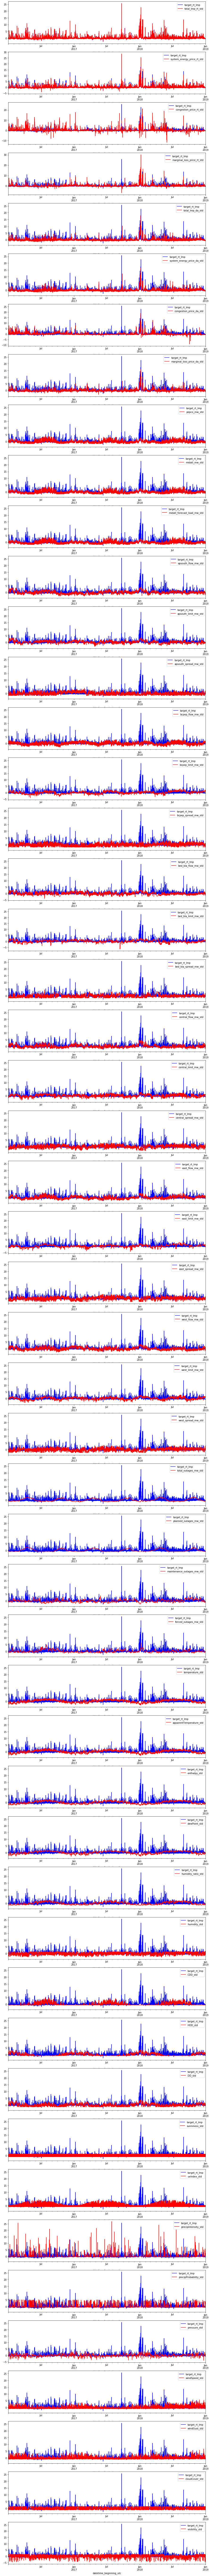

In [28]:
# plotting standardized real time price against other features
pd.plotting.register_matplotlib_converters()
fig, axes = plt.subplots(51, 1, figsize=(15, 200))
for i, col in enumerate(plot_df.columns[1:]):
    plot_df.plot(x='datetime_beginning_utc', y='total_lmp_rt_std',
                 color="b", label='target_rt_lmp', ax=axes[i])
    plot_df.plot(x='datetime_beginning_utc', y=col,
                 color="r", label=col, ax=axes[i])

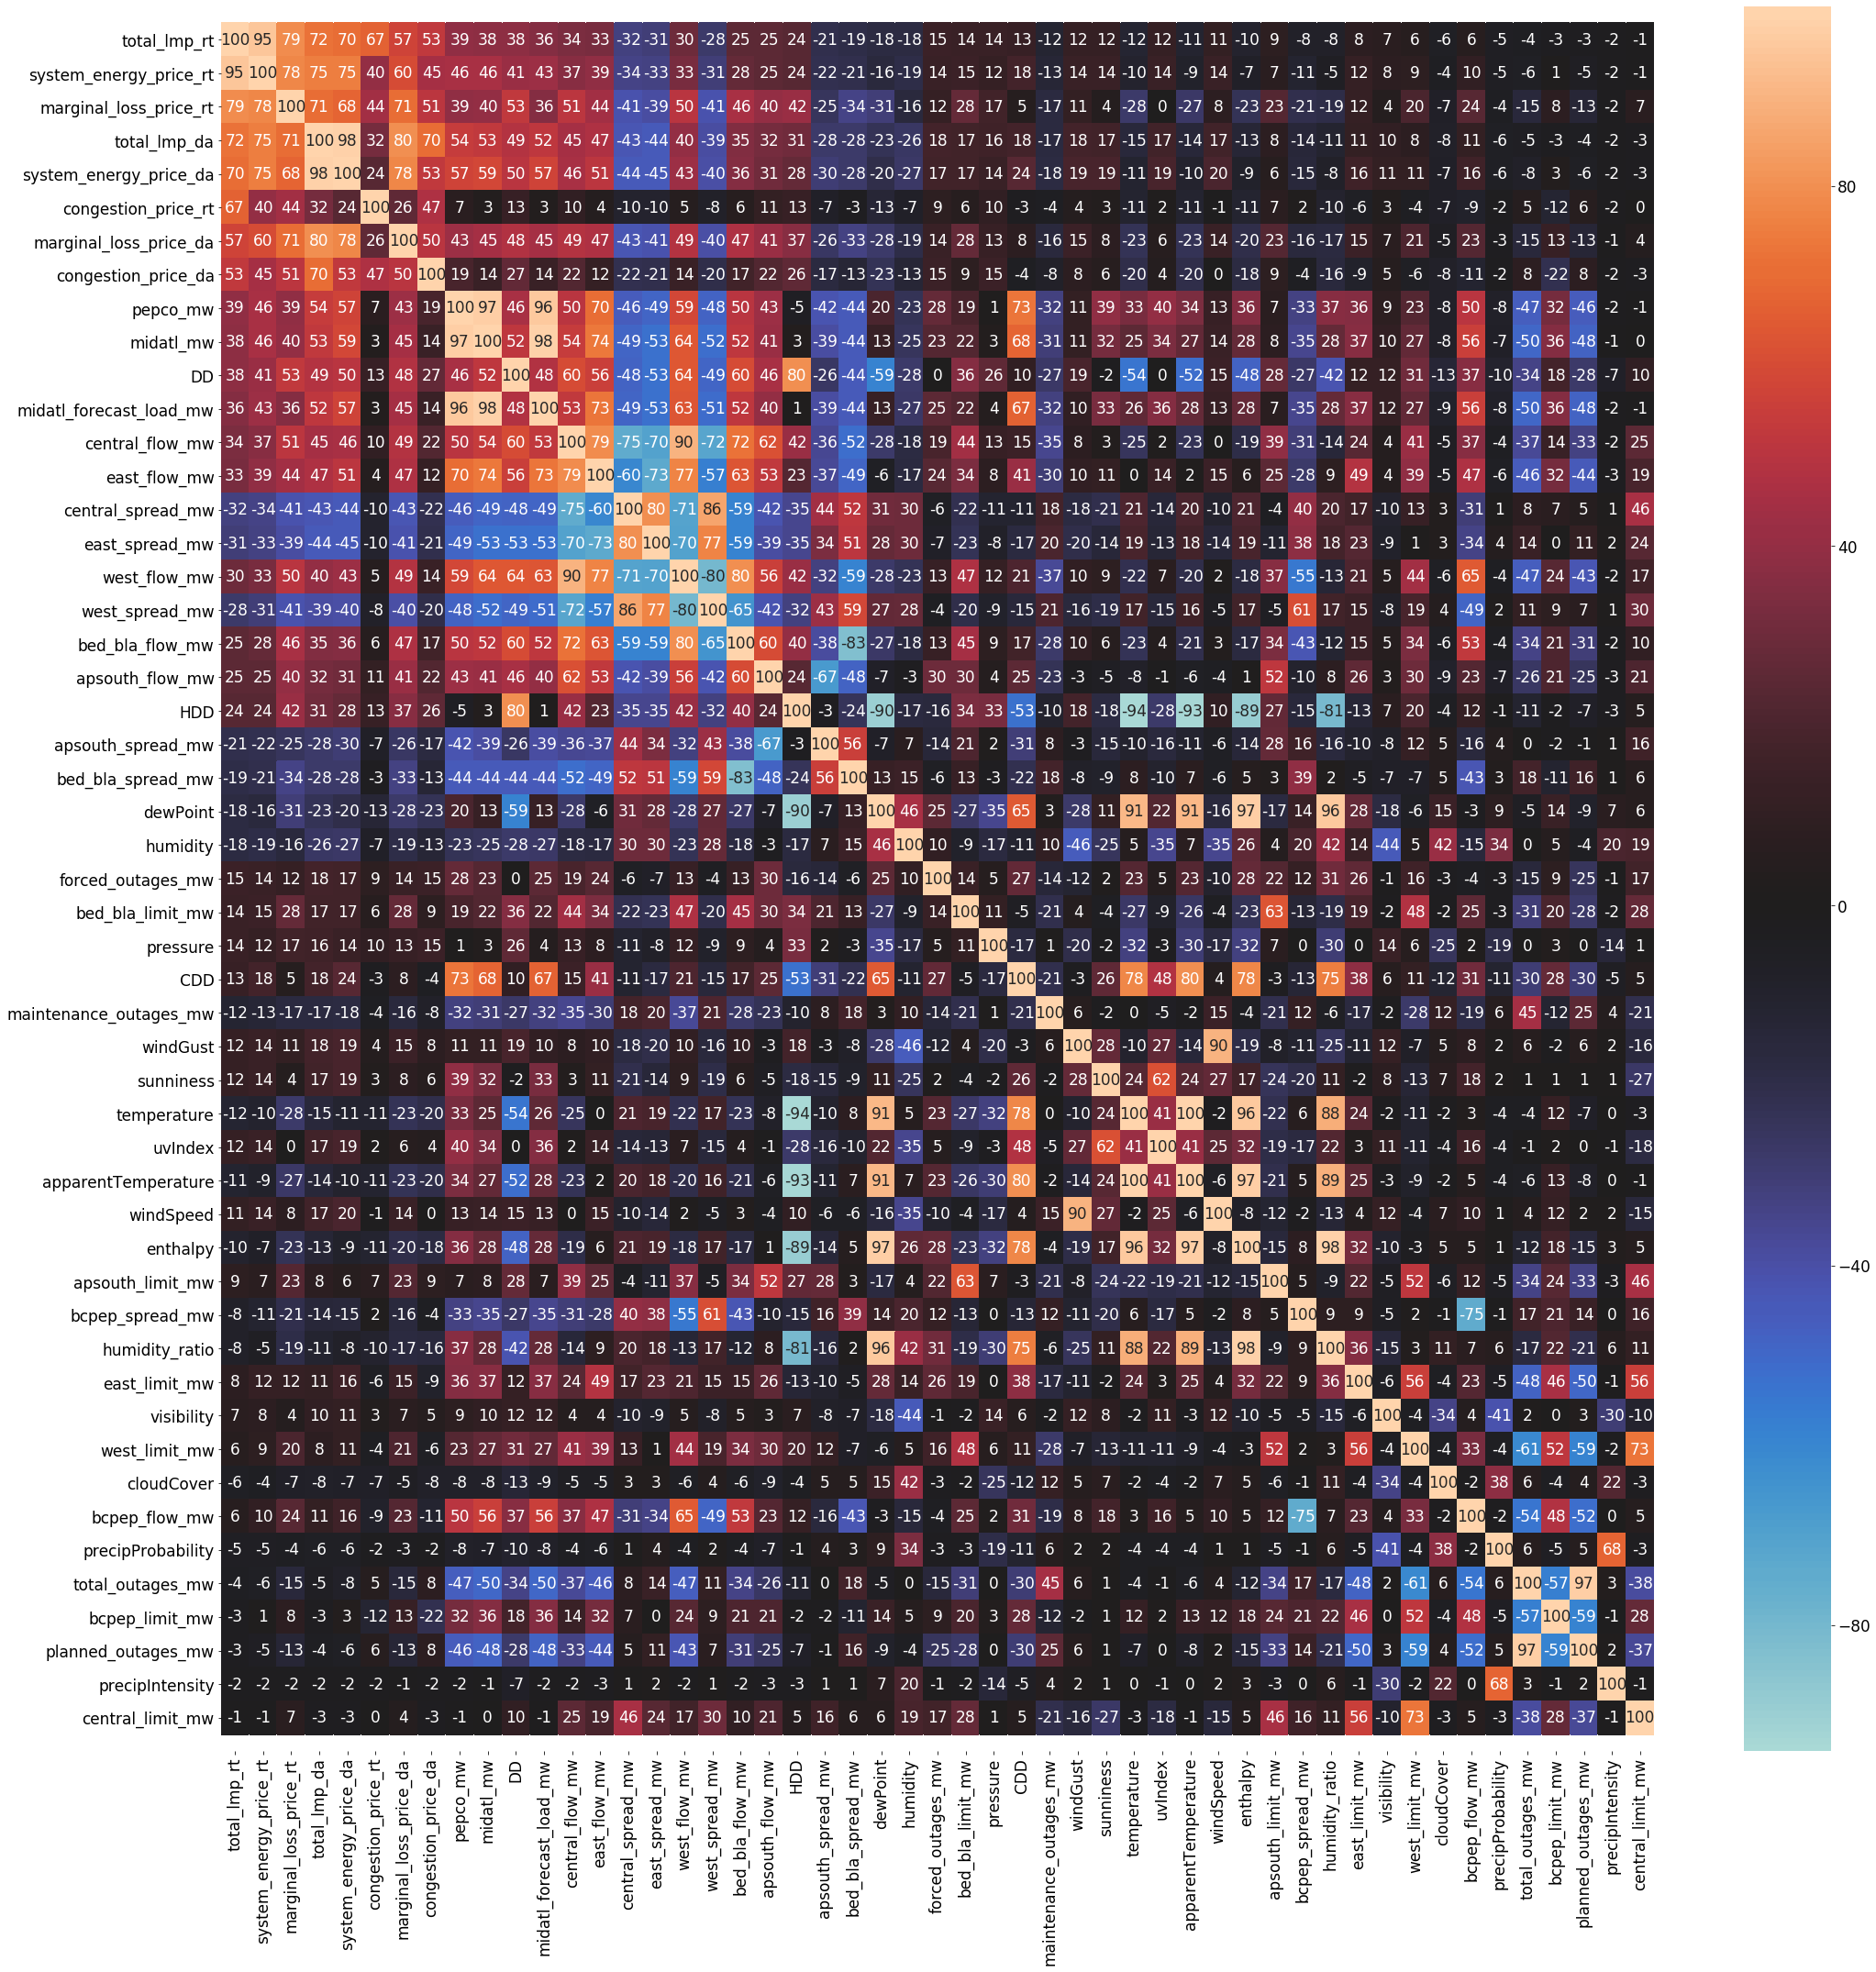

In [29]:
# observing data correlations
# creating the sort order
sorted_corr_series = train_data_std.corr().total_lmp_rt.abs().sort_values(ascending=False)
sorted_cols = list(sorted_corr_series.index)

# to allow for larger font sizes,
# the correlations are being rounded and multiplied by 100
sorted_corr_df = train_data_std[sorted_cols].corr().round(2)*100

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize = (35, 35))

sns.heatmap(sorted_corr_df.astype(int),
           center = 0, annot = True, fmt="d")

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
ax.set_ylim(len(train_data_std.columns)+0.5, -0.5);
plt.show;
plt.rcParams.update({'font.size': 10})

In [30]:
temporal = ['datetime_beginning_utc', 'datetime_beginning_ept']
# will consider separately forecasting each component of the price
price_targets = ['total_lmp_rt',
                 'system_energy_price_rt', 'congestion_price_rt', 'marginal_loss_price_rt']
# selected based on domain knowledge and correlation (visual and coefficient)
price_features = ['total_lmp_da', 'system_energy_price_da',
                  'congestion_price_da', 'marginal_loss_price_da', 'pepco_mw',
                  'apsouth_flow_mw', 'apsouth_spread_mw',
                  'bcpep_flow_mw', 'bcpep_spread_mw',
                  'bed_bla_flow_mw', 'bed_bla_spread_mw',
                  'central_flow_mw', 'central_spread_mw',
                  'east_flow_mw', 'east_spread_mw',
                  'west_flow_mw', 'west_spread_mw',
                  'maintenance_outages_mw', 'forced_outages_mw',
                  'dewPoint', 'enthalpy', 'apparentTemperature',
                  'DD', 'CDD', 'HDD', 'uvIndex', 'peak_hour',
                  'humidity', 'humidity_ratio']

In [31]:
price_df = data[temporal+price_targets+price_features]

In [32]:
# dropping features that aren't available for longer term (multiple days) load forecasts,
# but are available for shorter term (multiple hours) price forecasts.
short_term_cols = ['total_lmp_rt_std',
                   'system_energy_price_rt_std', 'congestion_price_rt_std',
                   'marginal_loss_price_rt_std', 'total_lmp_da_std',
                   'system_energy_price_da_std', 'congestion_price_da_std',
                   'marginal_loss_price_da_std', 'midatl_mw_std',
                   'midatl_forecast_load_mw_std',
                   'apsouth_flow_mw_std', 'apsouth_limit_mw_std', 'apsouth_spread_mw_std',
                   'bcpep_flow_mw_std', 'bcpep_limit_mw_std', 'bcpep_spread_mw_std',
                   'bed_bla_flow_mw_std', 'bed_bla_limit_mw_std', 'bed_bla_spread_mw_std',
                   'central_flow_mw_std', 'central_limit_mw_std', 'central_spread_mw_std',
                   'east_flow_mw_std', 'east_limit_mw_std', 'east_spread_mw_std',
                   'west_flow_mw_std', 'west_limit_mw_std', 'west_spread_mw_std']

mw_plot_df = plot_df.drop(columns=short_term_cols)

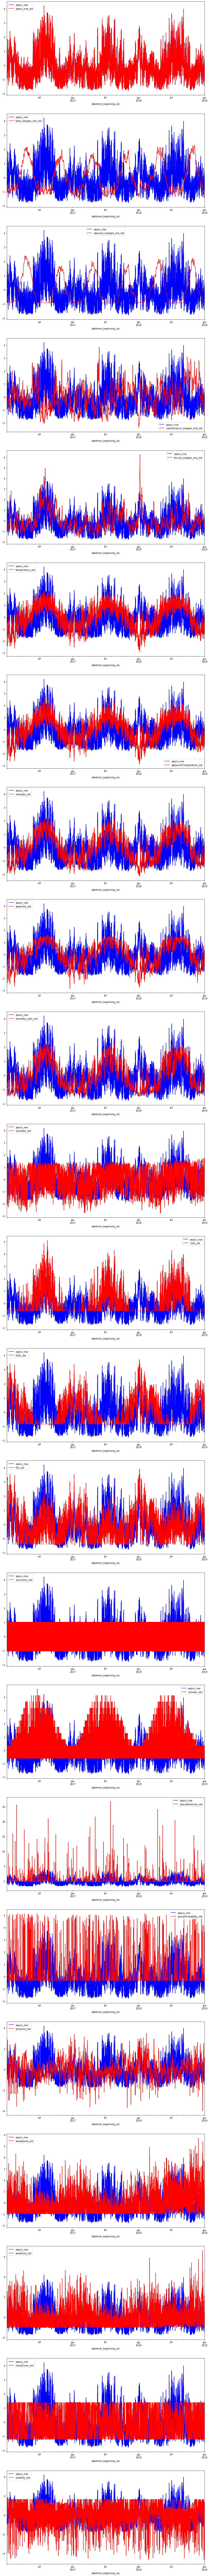

In [33]:
# plotting standardized Pepco MW against other features
pd.plotting.register_matplotlib_converters()
fig, axes = plt.subplots(23, 1, figsize=(15, 200))
for i, col in enumerate(mw_plot_df.columns[1:]):
    mw_plot_df.plot(x='datetime_beginning_utc', y='pepco_mw_std',
                    color="b", label='pepco_mw', ax=axes[i])
    mw_plot_df.plot(x='datetime_beginning_utc', y=col,
                    color="r", label=col, ax=axes[i])

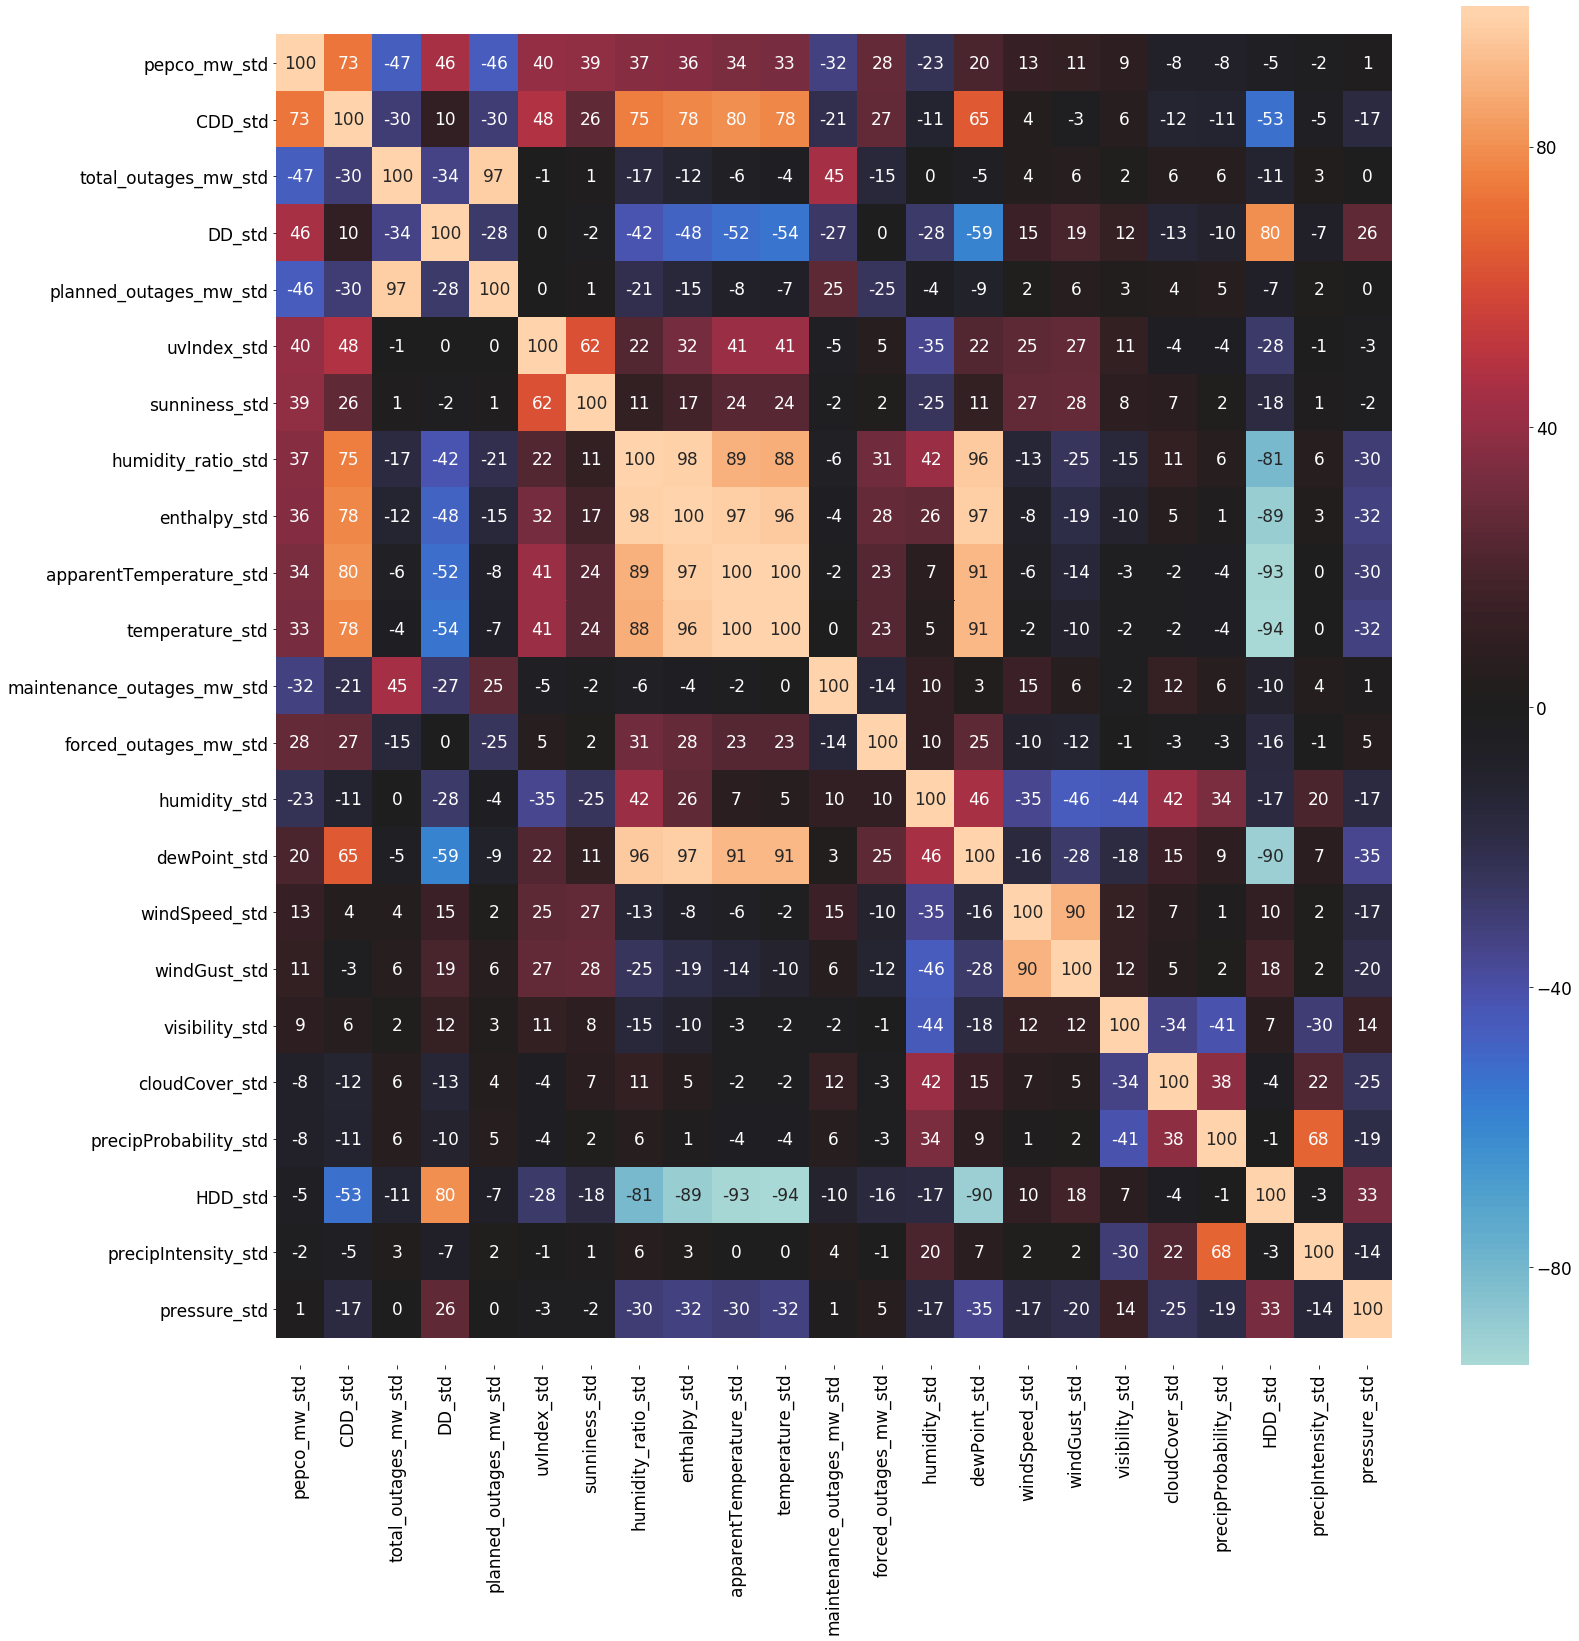

In [34]:
# observing data correlations
# creating the sort order
corr_data = mw_plot_df.drop(columns='datetime_beginning_utc')
sorted_corr_series = corr_data.corr().pepco_mw_std.abs().sort_values(ascending=False)
sorted_cols = list(sorted_corr_series.index)

# to allow for larger font sizes,
# the correlations are being rounded and multiplied by 100
sorted_corr_df = corr_data[sorted_cols].corr().round(2)*100

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(sorted_corr_df.astype(int),
           center = 0, annot = True, fmt="d")

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corr_data it
ax.set_ylim(len(corr_data.columns)+0.5, -0.5);
plt.show;
plt.rcParams.update({'font.size': 10})

In [35]:
temporal = ['datetime_beginning_utc', 'datetime_beginning_ept']
mw_targets = ['pepco_mw']
# selected based on domain knowledge and correlation (visual and coefficient)
mw_features = ['total_outages_mw', 'planned_outages_mw',
               'maintenance_outages_mw', 'forced_outages_mw',
               'enthalpy', 'apparentTemperature', 'dewPoint',
               'humidity', 'humidity_ratio', 'DD', 'CDD', 'HDD',
               'uvIndex', 'peak_hour']

In [36]:
mw_df = data[temporal+mw_targets+mw_features]

In [37]:
price_df.to_csv('data/processed/price_data.csv', index=False)

In [38]:
mw_df.to_csv('data/processed/mw_data.csv', index=False)